In [1]:
import os
import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from astropy import units as u
from edge_pydb import EdgeTable
from edge_pydb.xy2hist import xy2hist
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Spatially resolved SF law for EDGE.  
## x-axis: 7" CO intensity from the smoothed mask.  
## y-axis: Halpha flux from flux_elines smoothed to 7".

In [2]:
try: 
    hatab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm')
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    print('Working on full EDGE database')
except:
    hatab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm')
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
jointbl = join(cotab,hatab)
print(jointbl.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'sigmol', 'e_sigmol', 'flux_[OII]3727_sm', 'flux_[OIII]5007_sm', 'flux_[OIII]4959_sm', 'flux_Hbeta_sm', 'flux_[OI]6300_sm', 'flux_Halpha_sm', 'flux_[NII]6583_sm', 'flux_[NII]6548_sm', 'flux_[SII]6717_sm', 'flux_[SII]6731_sm', 'vel_[OII]3727_sm', 'vel_[OIII]5007_sm', 'vel_[OIII]4959_sm', 'vel_Hbeta_sm', 'vel_[OI]6300_sm', 'vel_Halpha_sm', 'vel_[NII]6583_sm', 'vel_[NII]6548_sm', 'vel_[SII]6717_sm', 'vel_[SII]6731_sm', 'disp_[OII]3727_sm', 'disp_[OIII]5007_sm', 'disp_[OIII]4959_sm', 'disp_Hbeta_sm', 'disp_[OI]6300_sm', 'disp_Halpha_sm', 'disp_[NII]6583_sm', 'disp_[NII]6548_sm', 'disp_[SII]6717_sm', 'disp_[SII]6731_sm', 'EW_[OII]3727_sm', 'EW_[OIII]5007_sm', 'EW_[OIII]4959_sm', 'EW_Hbeta_sm', 'EW_[OI]6300_sm', 'EW_Halpha_sm', 'EW_[NII]6583_sm', 'EW_[NII]6548_sm', 'EW_[SII]6717_sm', 'EW_[SII]6731_sm', 'e_flux_[OII]3727_sm', 'e_flux_[OIII]5007_sm', 'e_flux_[OIII]4959_sm', 'e_flux_Hbeta_sm', 'e_flux_[

In [4]:
# Apply a 3-sigma cut to both axes
det = (jointbl['mom0']>3*jointbl['emom0']) & (jointbl['flux_Halpha_sm']>3*jointbl['e_flux_Halpha_sm'])
codata = jointbl['mom0'][det]
hadata = jointbl['flux_Halpha_sm'][det]
sig_mol = jointbl['sigmol'][det]
sig_sfr = jointbl['flux_sigsfr_sm'][det]
print('Number of CO and Ha detections:',len(codata))

Number of CO and Ha detections: 4034


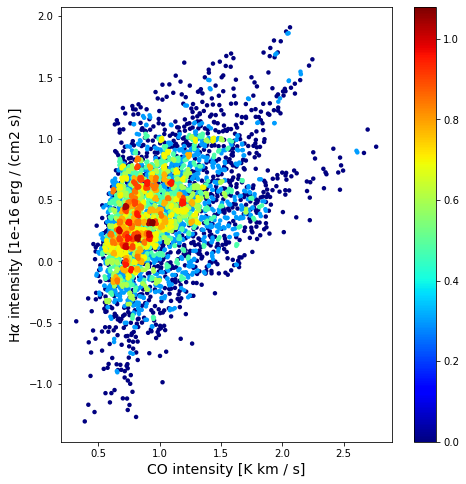

In [5]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(codata, hadata, log=True)
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
plt.xlabel('CO intensity ['+str(codata.unit)+']',fontsize=14)
plt.ylabel(r'H$\alpha$ intensity ['+str(hadata.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)

In [6]:
not_nan = (~np.isnan(sig_mol)) & (~np.isnan(sig_sfr)) & (sig_mol>0) & (sig_sfr>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

Excluding 9 invalid values
Number of valid points: 4025


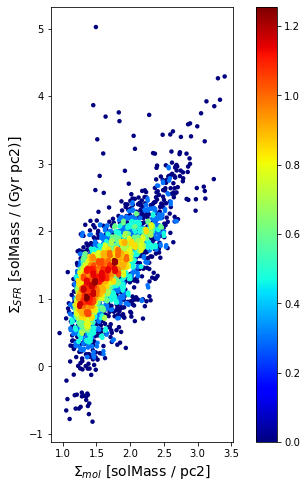

In [7]:
# Make the scatter plot (physical values)
x_det, y_det, z_det, *hist = xy2hist(sig_mol[not_nan], sig_sfr[not_nan], log=True)
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
plt.xlabel(r'$\Sigma_{mol}$ ['+str(sig_mol.unit)+']',fontsize=14)
plt.ylabel(r'$\Sigma_{SFR}$ ['+str(sig_sfr.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)